In [68]:
import networkx as nx
import pandas as pd
from tqdm import tqdm
from glob import glob
from collections import Counter

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
fp = fm.FontProperties(fname=font_path)
font = fm.FontProperties(fname=font_path,weight='bold',size=17)

jsons = glob('tweets/*.json')
for i, f in enumerate(jsons):
    print(i,f)

0 tweets/#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
1 tweets/test.json
2 tweets/#saveวันเฉลิม.json
3 tweets/#ธรรมศาสตร์และการชุมนุม.json
4 tweets/#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
5 tweets/#25พฤศจิกาไปSCB.json
6 tweets/#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
7 tweets/#ม็อบ2ธันวา.json


In [22]:
df = pd.read_json(jsons[5], lines=True)

### df of reply ###
#df = df[df.reply_to.apply(len) > 0]
#df[['username','reply_to']]


### df of mentions ###
#df = df[df.mentions.apply(len) > 0]
#df[['username','mentions']]


### df of quote tweet ###
#all_link = df.link
#df = df[df.quote_url.isin(all_link)]
#df

In [62]:
replydf = pd.DataFrame(columns=['replier','replyee','date'])

"""
### for reply or mention ###
for i, row in df.iterrows():
    for dic in row['reply_to']:
        replydf.loc[len(replydf)] = [row['username'], dic['screen_name']]
"""
        
### for quote_link ###
all_link = sorted(df.link)
c = 0
d = set()
for i, row in tqdm(df.iterrows()):
    replier = row['username']
    quote = row['quote_url']
    date = row['created_at']
    if quote in all_link:
        c += 1
        replyee = quote.split('/')[3]
        d.add(replyee)
        replydf.loc[len(replydf)] = [replier, replyee,date]
    

49050it [03:12, 255.30it/s]


In [6]:
set(replydf.replier) & set(replydf.replyee)

set()

In [39]:
### make count dictionary ###

edge_count = Counter()
for  j, i in zip(replydf.replyee, replydf.replier):
    edge_count[(i,j)] += 1
    
edge_count.most_common(5)

[(('laforthailand', 'KhaosodEnglish'), 16),
 (('ricardomdandrad', 'LAForThailand'), 7),
 (('laforthailand', 'ThaiEnquirer'), 7),
 (('phrayataksin033', 'ThaiEnquirer'), 7),
 (('naruepoyn2', 'Naruepoyn2'), 6)]

In [41]:
node_count = {} # node: [replied, reply]
for i in replydf.replyee:
    if i not in node_count:
        node_count[i] = [1,0]
    else:
        node_count[i][0] += 1
for i in replydf.replier:
    if i not in node_count:
        node_count[i] = [0,1]
    else:
        node_count[i][1] += 1

In [56]:
replydf.replyee.value_counts().head(10)

FreeYOUTHth        320
realkullllabcd     263
momo25402          208
kugkigz            171
tanawatofficial    168
joe_black317       164
Moja29563076       158
ThaiEnquirer       131
JKS05949033        116
mensblack_         116
Name: replyee, dtype: int64

In [52]:
replydf.replier.value_counts()

spoyyyy1          54
rsjnzkm           53
thatamm23         48
10_do_p           47
__iceeprincess    43
                  ..
donttellmetodo     1
mew_cg             1
thiswaymygray      1
bestbally          1
jpeach52823951     1
Name: replier, Length: 3864, dtype: int64

In [63]:
replydf
#replydf.drop_duplicates()

replier        replyee                      date
0         yooongiiahh      yeajirene 2020-11-27 20:14:08+07:00
1          mememyroam      momo25402 2020-11-27 15:16:45+07:00
2     v17lnretjm7g7wf        amimeaw 2020-11-27 08:45:57+07:00
3          nnnnaughty      naazuokaa 2020-11-26 22:57:02+07:00
4            veeza410      yeajirene 2020-11-26 22:57:01+07:00
...               ...            ...                       ...
9376       babyzhanse    FreeYOUTHth 2020-11-24 22:28:48+07:00
9377      haveabooday    FreeYOUTHth 2020-11-24 22:28:23+07:00
9378          sincare    FreeYOUTHth 2020-11-24 22:28:10+07:00
9379        ty_ington  ThammasatUFTD 2020-11-24 22:28:08+07:00
9380       my_dream_m    FreeYOUTHth 2020-11-24 22:27:07+07:00

[9381 rows x 3 columns]

# network

In [42]:
G = nx.DiGraph()  # Directed Graph

# add nodes
for node, tpl in node_count.items():
    if tpl[0] > tpl[1]:
        color = 'lightcoral'
    else:
        color = 'skyblue'
    G.add_node(node, color=color)
    
# add edges
G.add_weighted_edges_from([k+(v,) for k,v in edge_count.items()])

# ネットワーク全体の次数の平均値を計算
average_deg = sum(d for n, d in G.degree()) / G.number_of_nodes()

# ノードの次数に比例するようにサイズを設定
sizes = [300*deg/average_deg for node, deg in G.degree()]
edge_width = [d["weight"] * 1 for (u, v, d) in G.edges(data=True)]
node_color = [node["color"] for node in G.nodes.values()]

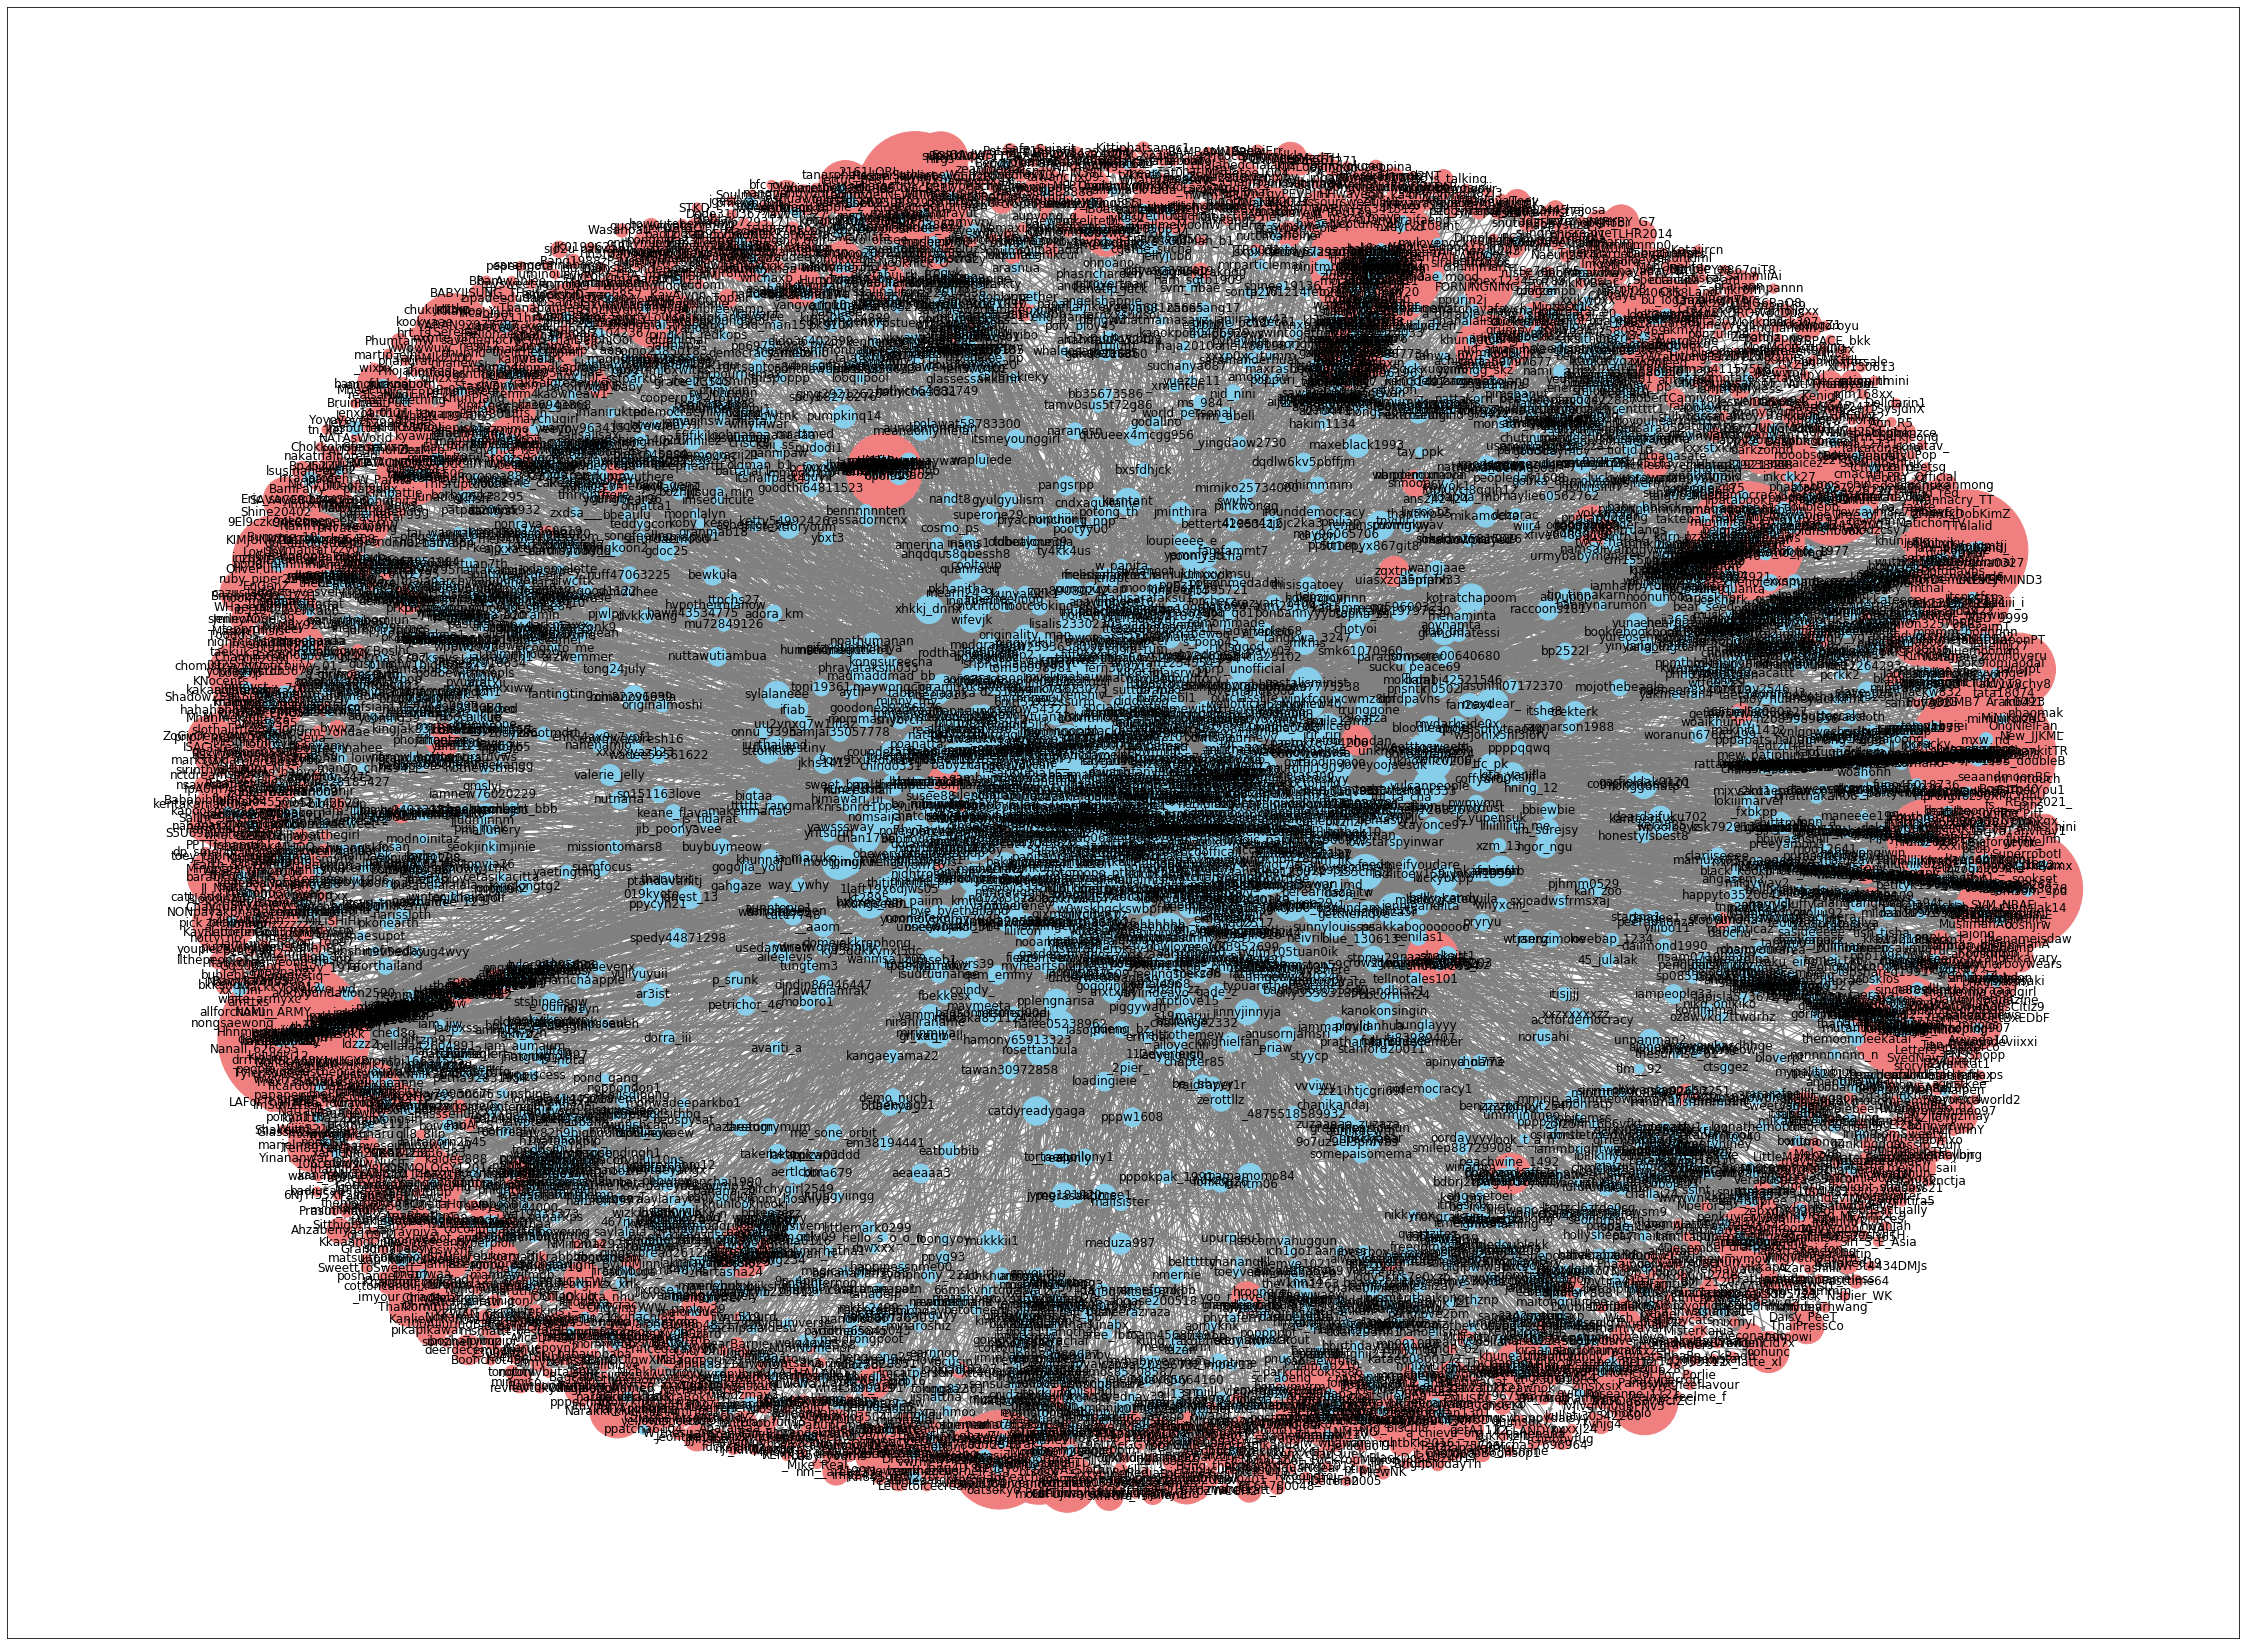

In [43]:
plt.figure(figsize=(40,30))
#pos = nx.circular_layout(G)
nx.draw_networkx(G, with_labels = True, node_color=node_color, edge_color="gray", node_size=sizes, width=edge_width)
plt.show()

In [44]:
### show cluster -- remove small network ###
node_to_remove = set()
for node, deg in G.degree():
    if deg <= 1:
        neighbor = list(G.predecessors(node)) + list(G.successors(node))
        neighbor_deg = G.degree()(neighbor[0])
        if neighbor_deg == 1:
            node_to_remove.add(node)
            node_to_remove.add(neighbor[0])
            
for node in node_to_remove:
    G.remove_node(node)

In [48]:
#cluster

nx.nx_agraph.view_pygraphviz(G, prog='fdp') 

('/var/folders/11/c2p61qts52951q5sy1qzkdnh0000gn/T/tmpz8lf_eno.png',
 <AGraph <Swig Object of type 'Agraph_t *' at 0x7f8424441270>>)

In [64]:
# repliers

print("|replier|count|\n|:-:|:-:|")
i = 0
most_replier = []
for name, count in replydf.replier.value_counts().iteritems():
    print(f"|[@{name}](https://twitter.com/{name})|{count}|")
    i += 1
    most_replier.append(name)
    if i >= 10:
        break

|replier|count|
|:-:|:-:|
|[@spoyyyy1](https://twitter.com/spoyyyy1)|54|
|[@rsjnzkm](https://twitter.com/rsjnzkm)|53|
|[@thatamm23](https://twitter.com/thatamm23)|48|
|[@10_do_p](https://twitter.com/10_do_p)|47|
|[@__iceeprincess](https://twitter.com/__iceeprincess)|43|
|[@athena31102](https://twitter.com/athena31102)|39|
|[@byunminn](https://twitter.com/byunminn)|37|
|[@ckbadb](https://twitter.com/ckbadb)|36|
|[@jjdemo3](https://twitter.com/jjdemo3)|32|
|[@gambum28953833](https://twitter.com/gambum28953833)|31|


In [65]:
# replyees

print("|replyee|count|\n|:-:|:-:|")
i = 0
most_replyee = []
for name, count in replydf.replyee.value_counts().iteritems():
    print(f"|[@{name}](https://twitter.com/{name})|{count}|")
    i += 1
    most_replyee.append(name)
    if i >= 10:
        break

|replyee|count|
|:-:|:-:|
|[@FreeYOUTHth](https://twitter.com/FreeYOUTHth)|320|
|[@realkullllabcd](https://twitter.com/realkullllabcd)|263|
|[@momo25402](https://twitter.com/momo25402)|208|
|[@kugkigz](https://twitter.com/kugkigz)|171|
|[@tanawatofficial](https://twitter.com/tanawatofficial)|168|
|[@joe_black317](https://twitter.com/joe_black317)|164|
|[@Moja29563076](https://twitter.com/Moja29563076)|158|
|[@ThaiEnquirer](https://twitter.com/ThaiEnquirer)|131|
|[@JKS05949033](https://twitter.com/JKS05949033)|116|
|[@mensblack_](https://twitter.com/mensblack_)|116|


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on 

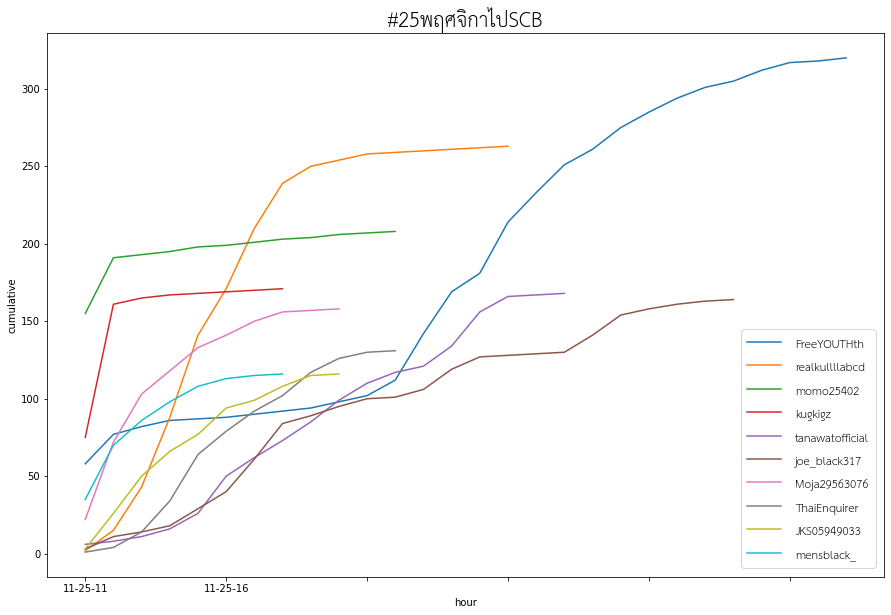

In [70]:
def tohour(date):
    if date.day < 10:
        day = f"0{date.day}"
    else:
        day = str(date.day)
    if date.hour < 10:
        hour = f"0{date.hour}"
    else:
        hour = str(date.hour)
    return f"{date.month}-{day}-{hour}"
        

fig = plt.figure(figsize=(15,10))
for name in most_replyee:
    tempdf = replydf[replydf.replyee == name]
    tempdf['hour'] = tempdf['date'].apply(tohour)
    
    tempdf.groupby(tempdf["hour"]).count()['replier'].sort_index().cumsum().plot(label=name)
plt.title('#25พฤศจิกาไปSCB', fontproperties=fp, fontsize=30)
plt.legend(prop=font)
plt.ylabel('cumulative')
plt.show()

In [25]:
nx.draw_networkx?

Signature: nx.draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
Docstring:
Draw the graph G using Matplotlib.

Draw the graph with Matplotlib with options for node positions,
labeling, titles, and many other drawing features.
See draw() for simple drawing without labels or axes.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary, optional
   A dictionary with nodes as keys and positions as values.
   If not specified a spring layout positioning will be computed.
   See :py:mod:`networkx.drawing.layout` for functions that
   compute node positions.

arrows : bool, optional (default=True)
   For directed graphs, if True draw arrowheads.
   Note: Arrows will be the same color as edges.

arrowstyle : str, optional (default='-|>')
    For directed graphs, choose the style of the arrowsheads.
    See :py:class: `matplotlib.patches.ArrowStyle` for more
    options.

arrowsize : int, optional (default=10)
   For directed graphs, choose the size of the arrow 